# Vectors for Words

The approach to classification that we explored until now was based on the bag-of-word concept and the TF-IDF vectorization based on the work of Luhn (1957) and Sparck Jones (1972).

Luhn, H.P. (1957) ‘A Statistical Approach to Mechanized Encoding and Searching of Literary Information’, IBM Journal of Research and Development, 1(4), pp. 309–317. Available at: https://doi.org/10.1147/rd.14.0309.

Spärck Jones, K. (1972) ‘A Statistical Interpretation Of Term Specificity And Its Application In Retrieval’, Journal of Documentation, 28(1), pp. 11–21. Available at: https://doi.org/10.1108/eb026526.

Now we will turn our attention to more recent approaches for representing text data. First, however, we take a minute to consider what human language actually is.

![https://imgs.xkcd.com/1576](https://imgs.xkcd.com/comics/i_could_care_less.png)

- Human languages are social structures
- They are constructed by humans meant to be interpreted by humans
- Languages are a very recent invention (ca. 100,000 years ago, according to some estimates), written languages even more so (ca. 5,000 years ago). Compare this to the human evolution: https://www.britannica.com/science/human-evolution
- A lot of the knowledge is contained in language (books)

How can we represent the meaning of a word?

From the Cambridge Dictionary:

The meaning of something is what it expresses or represents:

- The word "flight" has two different meanings: a plane journey, and the act of running away.
- The meaning of his gesture was clear.
- His novels often have (a) hidden meaning.


In [2]:
from nltk.corpus import wordnet as wn

synset = wn.synsets('good')[1]

print("Name of the synset", synset.name())
print("Meaning of the synset : ", synset.definition())
print("Hypernyms ", synset.hypernyms())

Name of the synset good.n.02
Meaning of the synset :  moral excellence or admirableness
Hypernyms  [Synset('morality.n.01')]


Wordnet a thesaurus

- Subjective
- May lack nuance
- May not be up-to-date with new words or new meanings of existing words


In our previous discussion; word representations were discrete. In a dictionary with six
words, a one hot encoding of each word would be 0-1 six dimensional vectors.

icecream = [0 0 0 1 0 0]
gelato = [0 0 0 0 0 1]

No notion of word similarity. Icecream and gelato are basically the same thing, but these vectors are actually orthogonal.

WordNet could not handle it. Apart from inside/outside synset, no notion of similarity.


Distributional semantics: A word's meaning is given by the words that frequently appear close to it

![J.R. Firth](https://www.alvinleong.info/sfg/sfgfirth.jpg)


J.R. Firth 1975: "You shall know a word by the company it keeps"

The idea: use the contexts of the word to build up a representation of w

The northern **pike** is a largely solitary predator.
She said Wednesday that she will “definitely debut” another new skill, a Yurchenko double **pike** on vault, before Tokyo.
The gunslinging 5-foot-4-inch president galloped on the **pike** toward Bladensburg.
The **pike** population decreased in the following years due to droughts.


Mikolov, T. et al. (2013) ‘Efficient Estimation of Word Representations in Vector Space’. Available at: https://doi.org/10.48550/ARXIV.1301.3781.

Build dense, real valued vectors from the context of the word.

- embeddings
- neural word representations
- distributed representations

In [ ]:
# pike
[-2, 0.5, 0.874, 0.565]

The idea:
- Take a large body (corpus) of text
- Map every word in that corpus to a (dense) vector of a fixed dimension (e.g., 300)
- Take each word (center word, c) in the text and try to predict the words that appear close to it in the text (context words, o)
- Use the *similarity* of the word vectors for c and o to calculate the probability of o given c
- Keep moving to the next word and adjust the word vectors to maximize this probability


Let's see an example.

$$
m = 2
$$

- **She** said Wednesday | that she will “definitely debut” another new skill, a Yurchenko double pike on vault, before Tokyo.
- |She **said** Wednesday that | she will “definitely debut” another new skill, a Yurchenko double pike on vault, before Tokyo.
- |She said **Wednesday** that she | will “definitely debut” another new skill, a Yurchenko double pike on vault, before Tokyo.

![Word2Vec Diagram](https://miro.medium.com/v2/1*cuOmGT7NevP9oJFJfVpRKA.png)

What was the dot product?

What was the dot product?

$$
a = \begin{pmatrix}
a_1 \\
a_2 \\
\vdots
a_n
\end{pmatrix}
\quad
x = \begin{pmatrix}
x_1 \\
x_2 \\
\vdots
x_n
\end{pmatrix}
$$

The dot product is defined as

$$
a \cdot x = a^T x = a_1 x_1 + a_2 x_2 + \ldots a_n x_n
$$

It is easy to see that for the angle between two vector $\vartheta$ holds the following:

$$
cos(\vartheta) = \frac{a \cdot x}{||a||\cdot ||x||}
$$


In [ ]:
import numpy as np

a = np.array([1, 2, 3])
x = np.array([2, 5, 1])

np.dot(a, x)

a_c = a - a.mean()
x_c = x - x.mean()

np.dot(a_c, x_c) / np.sqrt((np.sum(a_c ** 2) * np.sum(x_c ** 2)))

np.corrcoef(a, x)

For each position $t = 1,\ldots\,T$, predict the context words within a window of fixed size m, given a center word $w_j$.

Likelihood:

$$
L(\theta) = \prod_{t = 1}^{T} \prod_{-m \leq j \leq m, j \neq 0} P(w_{t + j} | w_t, \theta)
$$


The objective function $J(\theta)$ is the average negative log-likelihood

$$
J(\theta) = - \frac{1}{T}\log L(\theta) = - \frac{1}{T}\sum_{t = 1}^{T} \sum_{-m \leq j \leq m, j\neq 0 } \log P(w_j | w_t, \theta)
$$

We want to minimize the loss which implies to maximize the predictive accuracy.

Log, because it is easier to work with sums rather than with products.


The key part is to answer the question; how to calculate $P(w_{t + j} | w_{t}, \theta)$

We will use two vectors per word $w$

$v_w$ when w is a center word
$u_v$ when w is the context word

For the center word c and a context word o

$$
P(o|c) = \frac{\exp(u_{o}^T v_c)}{\sum_{w \in V} \exp(u_{o}^T v_c)
$$

The denominator serves to normalize to probabilities over the entire vocabulary.

The dot-product of the two vectors is a natural measure of similarity. A larger dot-product  implies a larger probability.

$$
\text{softmax}(x_i) = \frac{\exp(x_i)}{\sum_{j = 1}^{n} \exp(x_j) = p_i
$$

- max: because exponentiation emphasizes large values!
- soft: because it will assign some probability to all values

To train a model, we gradually adjust parameters to minimize the loss


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return x**2 + 1 * x + 1

def gradient_f(x):
    return 2 * x + 1

learning_rate = 0.02

def gradient_descent(func, gradient, eta, x0, maxiter):
    x_old = x0

    x = []
    f_x = []
    for i in np.arange(maxiter):
        grad_x_old = gradient(x_old)
        x_next = x_old - eta * grad_x_old
        f_val = func(x_next)

        x_old = x_next
        x.append(x_next)
        f_x.append(f_val)
        print(f"Epoch {i}, x={x_next}, f(x) = {f_val}, f'(x) = {grad_x_old}")

    return np.array(x), np.array(f_x)

np.random.seed(4)

x_grad, f_x_grad = gradient_descent(
    f,
    gradient_f,
    x0 = np.random.random(),
    eta = 0.2,
    maxiter=20
)

Epoch 0, x=0.38021790340820594, f(x) = 1.5247835574803377, f'(x) = 2.9340596780273533
Epoch 1, x=0.02813074204492355, f(x) = 1.0289220806929216, f'(x) = 1.7604358068164119
Epoch 2, x=-0.18312155477304587, f(x) = 0.8504119490494517, f'(x) = 1.056261484089847
Epoch 3, x=-0.30987293286382755, f(x) = 0.7861483016578026, f'(x) = 0.6337568904539083
Epoch 4, x=-0.3859237597182965, f(x) = 0.7630133885968089, f'(x) = 0.3802541342723449
Epoch 5, x=-0.4315542558309779, f(x) = 0.7546848198948513, f'(x) = 0.22815248056340698
Epoch 6, x=-0.45893255349858675, f(x) = 0.7516865351621465, f'(x) = 0.1368914883380442
Epoch 7, x=-0.47535953209915205, f(x) = 0.7506071526583727, f'(x) = 0.0821348930028265
Epoch 8, x=-0.48521571925949125, f(x) = 0.7502185749570142, f'(x) = 0.0492809358016959
Epoch 9, x=-0.4911294315556948, f(x) = 0.7500786869845251, f'(x) = 0.029568561481017497
Epoch 10, x=-0.49467765893341686, f(x) = 0.750028327314429, f'(x) = 0.017741136888610454
Epoch 11, x=-0.4968065953600501, f(x) = 0.75

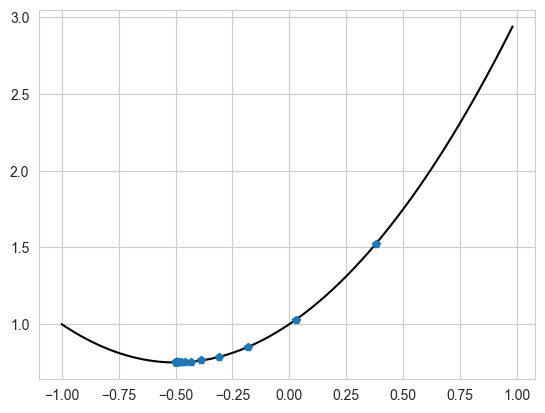

In [4]:
x = np.arange(-1, 1, .02)
y = f(x)

# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(x, y, 'k', label='Model length')
ax.plot(x_grad, f_x_grad, "p")
ax.plot()

plt.show()

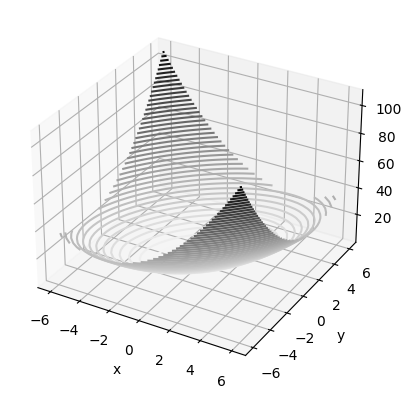

In [12]:
def f(x1, x2):
    return x1**2 + x2**2 - x1 * x2 + 1

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');



Recall: $\theta$ represents all model parameters in one long vector. In our case with d-dim vectors and V-many words, we have 

$$
\theta \in \mathbb{R}^{2dV}
$$

Now the question is: in what direction to move in order to update the parameters.

$$
J(\theta) = -\frac{1}{T}\sum \sum \log P(w_{t + j} | w_{t})\\
P(o|c) = \exp(u_o^Tv_c) / \sum \exp(u_w^Tv_c)
$$ 

What are the partial derivatives?

$$
\frac{\partial}{\partial v_c} \log(\frac{exp(u_o^Tv_c)}{\sum exp(u_w^Tv_c)})
$$

this is easy: $\log(x / y) = \log(x) - \log(y)$.

$$
\frac{\partial}{\partial v_c} \log \exp(u_o^Tv_c) - \frac{\partial}{\partial v_c} \log \sum \exp(u_w^Tv_c) = \\
$$

Let's deal with the numerator first.

$$
\frac{\partial}{\partial v_c} u_o^Tv_c
$$

This is a derivative with respect to a vector.
$$
\frac{d}{d x} ax = a \\
u_{o,1} v_{c,1} + u_{o,2} v_{c,2} + \ldots + u_{o,d} v_{c,d}
$$

Now the denominator

$$
\frac{\partial}{\partial} \log \sum \exp(u_w^Tv_c)
$$

The derivative of the logarithm is:

$$
f(x) = \log(x)\\
f'(x) = \frac{1}{x}
$$

so

$$
\frac{1}{\sum \exp(u_w^T v_c)}\frac{partial}{\partial v_c} \sum_{x = 1}^{V} \exp(u_x^T v_c) = \\
\frac{1}{\sum \exp(u_w^T v_c)} \sum_{x = 1}^{V} \frac{partial}{\partial v_c} \exp(u_x^T v_c) \\
\frac{1}{\sum \exp(u_w^T v_c)} \sum_{x = 1}^{V} \exp(u_x^T v_c) \frac{partial}{\partial v_c} u_x^T v_c \\
\frac{1}{\sum \exp(u_w^T v_c)} \sum_{x = 1}^{V} \exp(u_x^T v_c) u_x\\
$$

So finally, the whole derivative is

$$
\frac{\partial}{\partial} \log p(o|c) = u_o - \frac{\sum_{x = 1}^{V} exp(u_x^T v_c) u_x}{\sum_{w = 1}^{V} \exp(u_w^T v_c)} = 
u_o - \sum_{x = 1}^{V} p(x | c) u_x
$$

The model is good if it predicts on average the vector that we see.

What to expect about the predicted word probabilities?

In [5]:
import numpy as np
import gensim.downloader as gensim_api
model = gensim_api.load("glove-wiki-gigaword-100")
print(type(model))

<class 'gensim.models.keyedvectors.KeyedVectors'>


In [21]:
model["clinton"]

array([-0.38578  ,  0.27089  ,  0.99613  ,  0.34611  ,  0.4724   ,
        0.0077983,  0.28266  ,  0.41887  ,  0.018364 , -0.42688  ,
       -0.26021  , -0.18372  , -0.60997  ,  0.076138 , -0.018547 ,
       -0.10343  ,  0.24068  , -0.25114  , -0.54159  , -0.45323  ,
        0.099182 , -0.28826  , -0.39931  , -0.1422   , -0.49851  ,
        0.18567  , -0.79608  , -0.17189  , -0.013608 , -0.76797  ,
        1.1769   ,  0.99508  ,  0.61011  ,  0.66459  , -0.38258  ,
        0.976    ,  0.13394  , -0.45744  ,  0.15515  ,  1.1658   ,
       -1.453    , -0.94797  ,  0.69023  ,  0.28643  , -0.69622  ,
       -0.70189  ,  0.084855 , -0.47477  , -0.40689  , -1.296    ,
        0.70285  , -0.34714  ,  0.7959   ,  0.84087  ,  0.23243  ,
       -2.3365   ,  0.44022  , -0.34408  ,  0.8372   ,  0.49341  ,
       -0.52166  ,  0.38055  ,  0.25597  , -0.33058  ,  0.44759  ,
       -0.13727  ,  0.6202   ,  1.1774   , -0.13016  ,  0.087564 ,
        0.13531  , -0.19117  , -0.83744  , -0.19687  , -0.0981

In [16]:
model.most_similar("bulgaria")

[('romania', 0.886336088180542),
 ('hungary', 0.8389860391616821),
 ('ukraine', 0.8092954754829407),
 ('lithuania', 0.7841965556144714),
 ('latvia', 0.7808158993721008),
 ('albania', 0.7778776288032532),
 ('moldova', 0.7754805684089661),
 ('greece', 0.7619103193283081),
 ('armenia', 0.7605523467063904),
 ('slovakia', 0.7601156234741211)]

In [20]:
model.most_similar("pike")

[('elk', 0.6156542301177979),
 ('brook', 0.5954383611679077),
 ('creek', 0.5603739619255066),
 ('benton', 0.5585354566574097),
 ('cumberland', 0.5523167252540588),
 ('jasper', 0.5395222306251526),
 ('perch', 0.5297390818595886),
 ('grove', 0.5274512767791748),
 ('beaver', 0.5258278846740723),
 ('moose', 0.5208967328071594)]

In [10]:
model.most_similar(negative="apple")

[('hizon', 0.476315438747406),
 ('waly', 0.4709792733192444),
 ('marc-andre', 0.4691624343395233),
 ('kashinath', 0.4621971845626831),
 ('jharkand', 0.45896580815315247),
 ('belkhadem', 0.45566409826278687),
 ('joal', 0.45194777846336365),
 ('römischen', 0.45179906487464905),
 ('aldona', 0.45006662607192993),
 ('hincmar', 0.4497555196285248)]

King - Man + Woman

In [11]:
result = model.most_similar(positive = ["woman", "king"], negative = ["man"])
result

[('queen', 0.7698540687561035),
 ('monarch', 0.6843381524085999),
 ('throne', 0.6755736470222473),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534157752991),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.631171703338623),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

In [12]:
def analogy(x1, x2, y1):
    result = model.most_similar(positive=[y1, x2], negative = [x1])
    return result[0][0]

analogy("man", "king", "woman")

'queen'

In [13]:
analogy("king", "man", "queen")

'woman'

In [21]:
analogy("germany", "beer", "france")

'wine'

In [24]:
analogy("hammer", "building", "knife")

'residential'

Important on what data the model was trained...


In [19]:
analogy("obama", "clinton", "reagan")

'nixon'

In [15]:
from sklearn.manifold import TSNE

def plot_vecs_2d(words):
    "Creates and TSNE model and plots it"
    
    vecs = model[words]

    tsne_mod = TSNE(perplexity=2, n_components=2, init='pca', n_iter=3000, random_state=37)
    new_values = tsne_mod.fit_transform(vecs)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

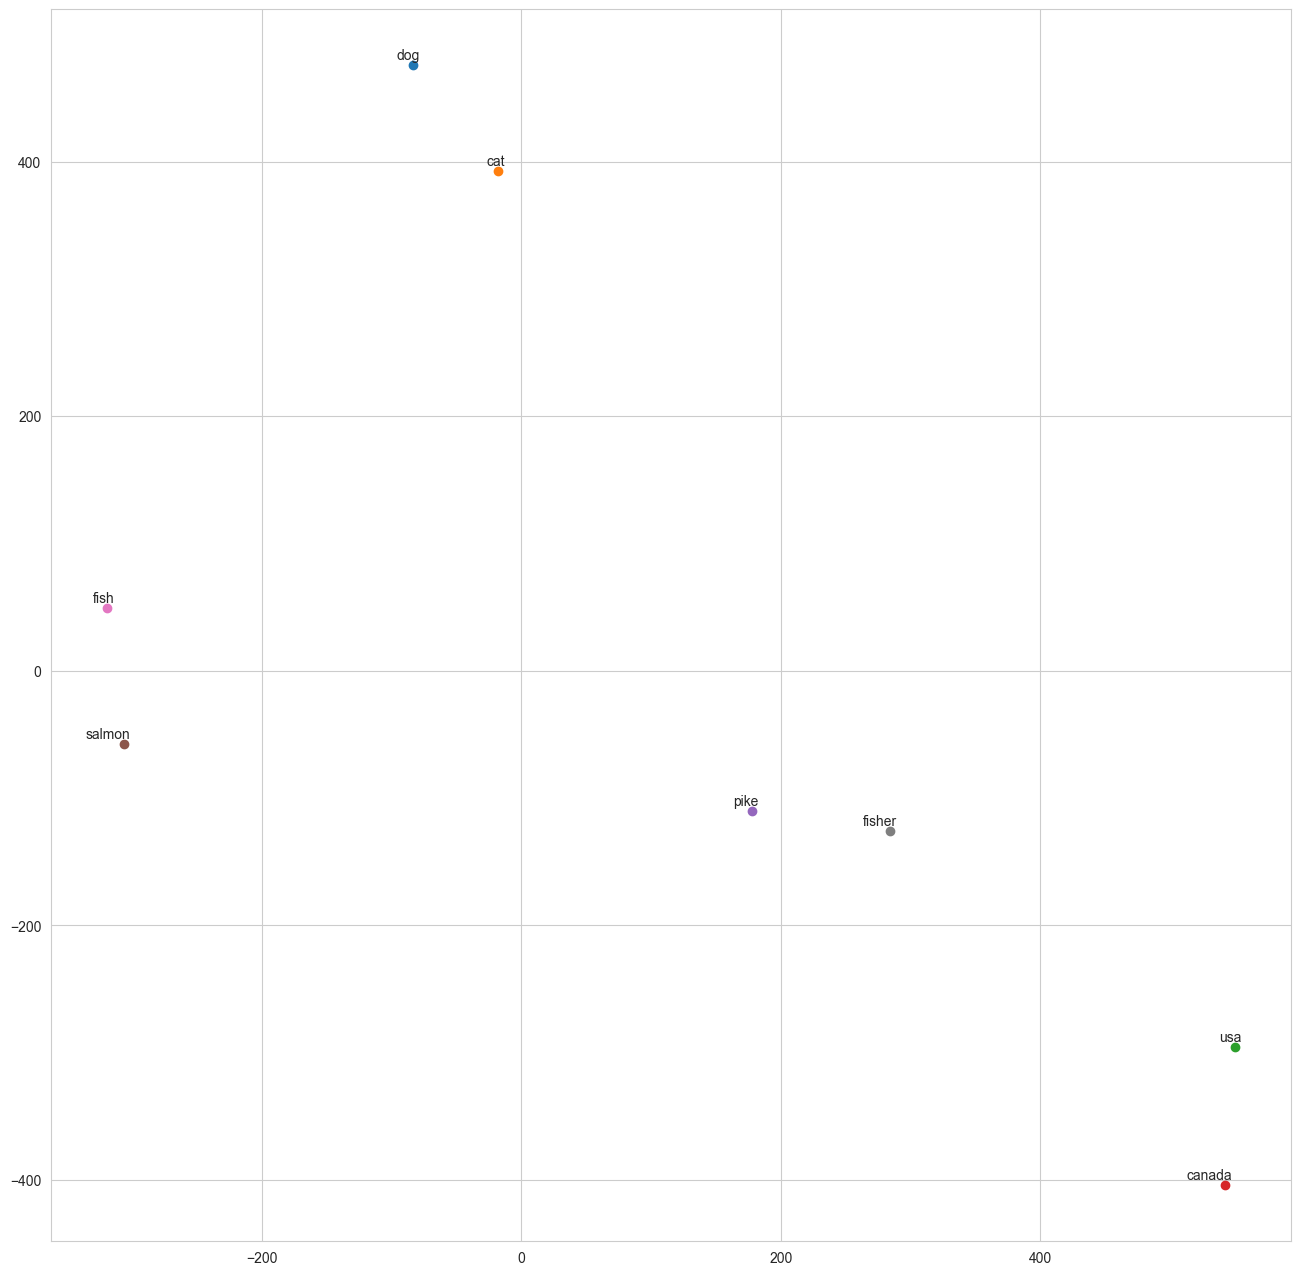

In [18]:
plot_vecs_2d(words = ["dog", "cat", "usa", "canada", "pike", "salmon", "fish", "fisher"])

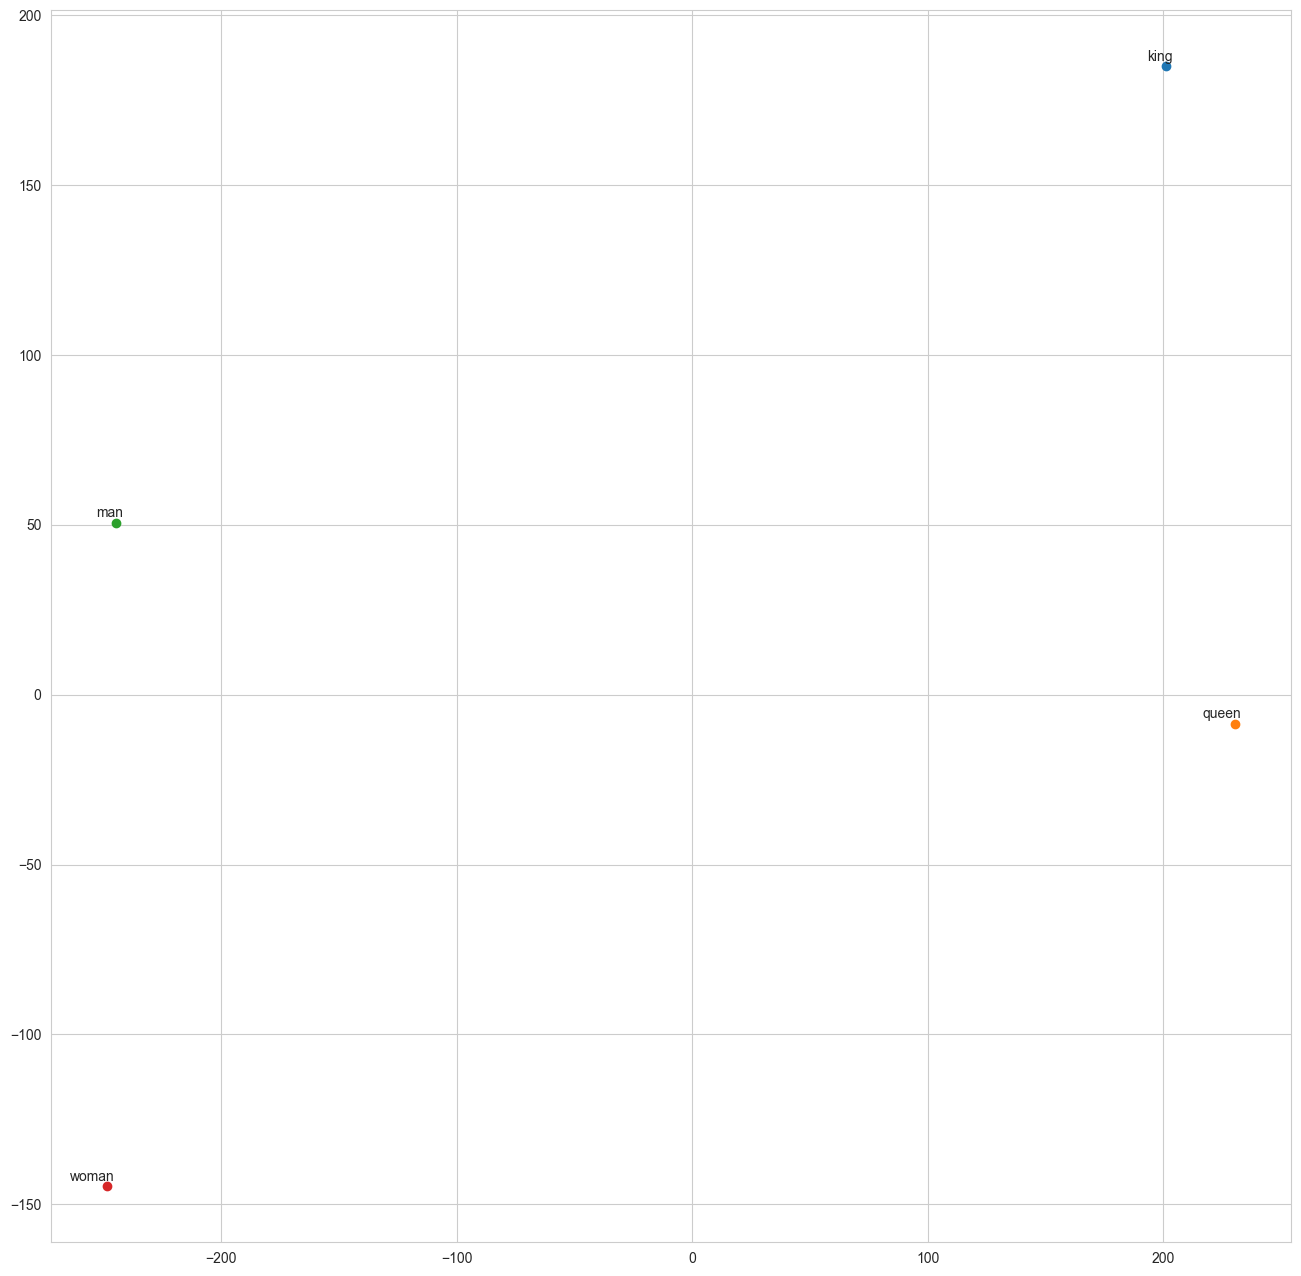

In [17]:
plot_vecs_2d(words = np.array(["king", "queen", "man", "woman"]))

In [38]:
model[["dog", "bark"]].T

array([[ 0.30817  , -1.3976   ],
       [ 0.30938  ,  0.68474  ],
       [ 0.52803  , -0.45203  ],
       [-0.92543  , -1.0325   ],
       [-0.73671  , -0.44786  ],
       [ 0.63475  ,  0.26848  ],
       [ 0.44197  , -1.0051   ],
       [ 0.10262  , -0.32016  ],
       [-0.09142  ,  0.020665 ],
       [-0.56607  , -0.32858  ],
       [-0.5327   ,  0.5525   ],
       [ 0.2013   ,  0.68554  ],
       [ 0.7704   ,  0.71975  ],
       [-0.13983  ,  1.078    ],
       [ 0.13727  ,  0.56806  ],
       [ 1.1128   ,  0.64844  ],
       [ 0.89301  ,  0.2959   ],
       [-0.17869  , -0.21145  ],
       [-0.0019722,  0.66408  ],
       [ 0.57289  ,  0.28304  ],
       [ 0.59479  , -0.2307   ],
       [ 0.50428  ,  0.45509  ],
       [-0.28991  ,  0.013227 ],
       [-1.3491   , -0.56472  ],
       [ 0.42756  ,  0.49104  ],
       [ 1.2748   ,  1.2187   ],
       [-1.1613   ,  0.14932  ],
       [-0.41084  , -0.36919  ],
       [ 0.042804 , -0.02261  ],
       [ 0.54866  , -0.1364   ],
       [ 0